In [7]:
import matplotlib.pyplot as plt
import os
import argparse
from ast import literal_eval
from IPython.display import Image
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import glob
from dateutil import parser

import pandas as pd
import numpy as np

from run import create_model
import config
from src.tests import acc_ir, plot_ir

df_indexed = None

conf = config.get_config(top_folder='outputs_retrain')
df = pd.read_csv(conf['database'])

# Only take the once with 200 iterations
# df = df[df.num_steps == 200]

# Parse arrays
df['incumbent'] = df.incumbent.fillna('None').apply(literal_eval)
df['immediate_regret'] = df.immediate_regret.fillna('None').apply(literal_eval)
df.date = df.date.astype('datetime64[ns]')

# Remove invalid seeds (set default seed)
df.loc[df.seed == -1, 'seed'] = 0

# Remove dublicates
df = df.sort_values(by=['date'])
df = df.groupby(["uuid"]).agg(lambda x: x.iloc[0]).reset_index()
df = df.sort_values(by=['date'])

# Make embedding into tuples to support hashing (used in groupby)
df.embedding = df.embedding.fillna('[]')
df.embedding = df.embedding.apply(literal_eval)
df.embedding = [ tuple(row.embedding) for _, row in df.iterrows() ]

def get_model_conf(uid):
    row = df_indexed.loc[uid]
    model_shortname = row['name']
    model_conf = config.get_model_config(uid, model_shortname, conf)
    return model_conf

def plot_ir_image(model_conf):
    display(Image(filename=model_conf['regret_plot_path']))

def plot_step_image(model_conf):
    # l = os.listdir(model_conf['plot_folder'])
    l_all = glob.glob(os.path.join(model_conf['plot_folder'], '*.png'))
    l_all.sort(key=lambda n: int(n.replace(".", "-").split('-')[-2]))
    l_em = [img for img in l_all if "embedding" in img]
    l = [img for img in l_all if "embedding" not in img]

    def show_image(i):
        if i < len(l):
            display(Image(filename=l[i]))
        if i < len(l_em):
            display(Image(filename=l_em[i]))
    
    length = max(len(l), len(l_em))
    # Only if there are images
    if length > 0:
        interact(show_image, i=widgets.IntSlider(min=0, max=length - 1, step=1, value=0))

def get_XY(model_conf):
    X = np.load(model_conf['obs_X_path'])
    Y = np.load(model_conf['obs_Y_path'])
    return X, Y
    
def recreate_model(uid, model_conf, train=True, extra_args=None):
    args_dict = df_indexed.loc[uid].to_dict()
    if extra_args is not None:
        args_dict.update(extra_args)
        
    args = argparse.Namespace(**args_dict)
    args.batch_size = int(args.batch_size) # quick fix
    args.seed = int(args.seed)             # quick fix
        
    bo = create_model(args)
    X,Y = get_XY(model_conf)
    bo.model.init(X, Y, train=train)
    return bo


import itertools
def get_regret_history(uids):
    max_hist = []
    for uid in uids:
        model_conf = get_model_conf(uid)
        bo = recreate_model(uid, model_conf, train=False)
        maxy = np.maximum.accumulate(bo.model.Y)

        # Remove output dimension
        maxy = maxy[:,0]

        max_hist.append(maxy)
    # Fills arrays of different length with NaN
    max_hist = np.array(list(itertools.zip_longest(*max_hist, fillvalue=np.nan))).T
    
    mean = np.nanmean(max_hist, axis=0)

    var = np.nanvar(max_hist, axis=0)
    # top = np.maximum(mean + np.sqrt(var), bo.f_opt)
    # bottom = np.maximum(mean - np.sqrt(var), bo.f_opt)
    return np.abs(mean + np.sqrt(var) - bo.f_opt), np.abs(mean - bo.f_opt), np.abs(mean - np.sqrt(var) - bo.f_opt), max_hist


def select_group(df, GROUP):
    global df_indexed
    df = df.copy()
        
    print(df.group.unique())
    if GROUP == 'ensemble_size':
        # Include all camelback in the ensemble_size group.
        df = df[(df.group == GROUP) | (df.obj_func == "camelback")]
    else:
        df = df[df.group == GROUP]

    # Give correct type (pytorch does not allow numpy.float64 and numpy.int64)
    for col in ['seed', 'dim_basis', 'dim_h1', 'dim_h2', 'num_nn', 'batch_size', 'epochs', 'num_mcmc', 'n_iter', 'n_init']:
        df[col] = df[col].astype(int)
    for col in ['lr', 'weight_decay']:
        df[col] = df[col].astype(float)

    df_indexed = df.set_index('uuid')

    # Group the same model and calc regret history
    uuid_keys = ['acq', 'batch_size', 'dim_basis', 'dim_h1', 'dim_h2',
                 'epochs', 'lr', 'model', 'n_iter', 'nn_aggregator', 'num_mcmc', 'num_nn',
                 'weight_decay', 'obj_func', 'embedding']
    gf = df.groupby(uuid_keys)
    df_agg = gf.agg(list).reset_index()
    df_agg['regret_history'] = df_agg.uuid.apply(get_regret_history)
    
    return df_agg

# Load plot afterwards to override..
% matplotlib inline

import seaborn as sns

plt.rcParams['figure.figsize'] = (15, 6)
sns.set_style("darkgrid")

# Plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [8]:
def show_regret(df_agg, default=None):
    from src.utils import random_hypercube_samples

    def show_ir(obj_func):
        model_rows = df_agg[(df_agg.obj_func == obj_func)]

        # Rand hist
        if obj_func != 'logistic_regression_mnist':
            uid = model_rows.iloc[0].uuid[0]
            model_conf = get_model_conf(uid)
            bo = recreate_model(uid, model_conf, train=False)
            rand_hist = bo.obj_func(random_hypercube_samples(bo.n_init + bo.n_iter, bo.bounds, rng=bo.rng))
            plt.plot(acc_ir(rand_hist, bo.f_opt), label="rand")
            plt.fill_between([],[],[])

        for i, row in model_rows.iterrows():
            # mean, var, originals = row['regret_history']
            top, mean, bottom, originals = row['regret_history']
            plt.plot(mean, label=row['name'][0])
            # plt.fill_between(np.arange(mean.shape[0]), mean + np.sqrt(var), mean - np.sqrt(var), alpha=.2)
            plt.fill_between(np.arange(mean.shape[0]), top, bottom, alpha=.2)
            #for orig in originals[:1]:
            #    plt.plot(orig)
            #break
        plt.yscale('log')
        plt.legend()

    options = df_agg.obj_func.unique()
    return interact(show_ir, obj_func=widgets.Dropdown(
        options=options,
        value=default if default is not None else options[0]))

def show_obj_func(df_agg, plot_predictions=False):
    from src.tests import acc_ir, plot_ir

    def show_prediction(obj_func, embedded):
        if None:
            return
        model_rows = df_agg[(df_agg.obj_func == obj_func)]

        for i, row in model_rows.iterrows():
            uid = row.uuid[0]
            name = row['name'][0]
            model_conf = get_model_conf(uid)
            bo = recreate_model(uid, model_conf, train=plot_predictions)#, extra_args=dict(num_nn=10, epochs=1000, batch_size=1000))
            print("Model:", name)
            #bo.embedded_dims is not None
            bo.plot_prediction(plot_predictions=plot_predictions, plot_embedded_subspace=embedded)

    return interact(show_prediction, obj_func=list(df_agg.obj_func.unique()), embedded=False)

# Parameter exploration

In [3]:
df_agg = select_group(df, 'epoch')
df_indexed

['epoch' 'embedding' 'l2' 'ensemble_size' 'minibatch' 'funcs' 'highdim' nan]


acq  batch_size                       date  dim_basis  dim_h1  \
uuid                                                                      
8c23c8c7  UCB        1000 2018-08-21 10:45:11.910062         50      50   
50540b04  UCB        1000 2018-08-21 10:45:12.031837         50      50   
09afd9fe  UCB        1000 2018-08-21 10:45:12.173160         50      50   
ea6ab4e9  UCB        1000 2018-08-21 10:45:12.185873         50      50   
6e107c52  UCB        1000 2018-08-21 10:45:12.187503         50      50   
6f15a85b  UCB        1000 2018-08-21 10:45:12.316869         50      50   
76c8c720  UCB        1000 2018-08-21 10:45:12.417693         50      50   
ab384be1  UCB        1000 2018-08-21 10:45:12.473030         50      50   
a2e99f4d  UCB        1000 2018-08-21 10:45:12.477819         50      50   

          dim_h2 embedding  epochs  group  immediate_regret      ...       \
uuid                                                             ...        
8c23c8c7      50        ()   10000  epoch  [9.09344203e-08]      ...        
50540b04      50        ()     100  epoch      [0.00062132]      ...        
09afd9fe      50        ()    1000  epoch  [9.09344203e-08]      ...        
ea6ab4e9      50        ()    1000  epoch      [0.00218487]      ...        
6e107c52      50        ()     100  epoch      [0.00295049]      ...        
6f15a85b      50        ()   10000  epoch       [0.0023512]      ...        
76c8c720      50        ()     100  epoch      [0.00014119]      ...        
ab384be1      50        ()   10000  epoch   [2.2690429e-05]      ...        
a2e99f4d      50        ()    1000  epoch  [1.67382068e-05]      ...        

         n_init  n_iter                                               name  \
uuid                                                                         
8c23c8c7     20     200  8c23c8c7--g-epoch-s-1-m-dngo-init-20-k-200-e-1...   
50540b04     20     200  50540b04--g-epoch-s-1-m-dngo-init-20-k-200-e-1...   
09afd9fe     20     200  09afd9fe--g-epoch-s-1-m-dngo-init-20-k-200-e-1...   
ea6ab4e9     20     200  ea6ab4e9--g-epoch-s-1-m-dngo-init-20-k-200-e-1...   
6e107c52     20     200  6e107c52--g-epoch-s-1-m-dngo-init-20-k-200-e-1...   
6f15a85b     20     200  6f15a85b--g-epoch-s-1-m-dngo-init-20-k-200-e-1...   
76c8c720     20     200  76c8c720--g-epoch-s-1-m-dngo-init-20-k-200-e-1...   
ab384be1     20     200  ab384be1--g-epoch-s-1-m-dngo-init-20-k-200-e-1...   
a2e99f4d     20     200  a2e99f4d--g-epoch-s-1-m-dngo-init-20-k-200-e-1...   

          nn_aggregator  num_mcmc num_nn num_steps   obj_func  seed  \
uuid                                                                  
8c23c8c7         median         0      1     200.0       levy     1   
50540b04         median         0      1     200.0  hartmann3     1   
09afd9fe         median         0      1     200.0       levy     1   
ea6ab4e9         median         0      1     200.0     sintwo     1   
6e107c52         median         0      1     200.0     sintwo     1   
6f15a85b         median         0      1     200.0     sintwo     1   
76c8c720         median         0      1     200.0       levy     1   
ab384be1         median         0      1     200.0  hartmann3     1   
a2e99f4d         median         0      1     200.0  hartmann3     1   

          weight_decay  
uuid                    
8c23c8c7           0.0  
50540b04           0.0  
09afd9fe           0.0  
ea6ab4e9           0.0  
6e107c52           0.0  
6f15a85b           0.0  
76c8c720           0.0  
ab384be1           0.0  
a2e99f4d           0.0  

[9 rows x 23 columns]

In [4]:
uid = '0ad63da0'
model_conf = get_model_conf(uid)
bo = recreate_model(uid, model_conf, train=False, extra_args=dict(epochs=1000, batch_size=100, lr=0.01))
bo.model.init(bo.model.X[:5], bo.model.Y[:5], train=True)
bo.plot_prediction()

KeyError: 'the label [0ad63da0] is not in the [index]'

In [6]:
uid = 'e209c25f' # gp '9c994b1d'
model_conf = get_model_conf(uid)
bo = recreate_model(uid, model_conf, train=False, extra_args=dict(epochs=1000, batch_size=100, lr=0.01))
bo.model.init(bo.model.X[:10], bo.model.Y[:10], train=True)
fig = bo.plot_2D_surface(use_plotly=True)
iplot(fig)

KeyError: 'the label [e209c25f] is not in the [index]'

In [15]:
uid = 'e209c25f' # gp '9c994b1d'
model_conf = get_model_conf(uid)
bo = recreate_model(uid, model_conf, train=False, extra_args=dict(num_mcmc=5, epochs=1000, batch_size=100, lr=0.01))
bo.model.init(bo.model.X[:20], bo.model.Y[:20], train=True)
fig = bo.plot_2D_surface(use_plotly=True)
iplot(fig)

This is the format of your plot grid:
[ (1,1) scene1 ]  [ (1,2) scene2 ]
[ (2,1) scene3 ]  [ (2,2) scene4 ]



- mean is equivalent to nn
- almost no uncertainty

## Epochs

In [9]:
df_agg = select_group(df, 'funcs')
show_regret(df_agg)

['epoch' 'embedding' 'l2' 'ensemble_size' 'minibatch' 'funcs' 'highdim' nan]


reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters

interactive(children=(Dropdown(description='obj_func', options=('bohachevsky', 'branin', 'camelback', 'forrest…

<function __main__.show_regret.<locals>.show_ir(obj_func)>

## Weight decay

In [26]:
df_agg = select_group(df, 'l2')
show_regret(df_agg, "hartmann3")

reconstraining parameters rbf.variance


['epoch' 'embedding' 'l2' 'ensemble_size' 'minibatch' 'funcs' 'highdim' nan]


interactive(children=(Dropdown(description='obj_func', index=1, options=('goldsteinprice', 'hartmann3'), value…

<function __main__.show_regret.<locals>.show_ir(obj_func)>

# Failure cases

In [43]:
df_agg = select_group(df, 'funcs')
show_regret(df_agg)

['epoch' 'embedding' 'l2' 'ensemble_size' 'minibatch' 'funcs' 'highdim' nan]


reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters

interactive(children=(Dropdown(description='obj_func', options=('bohachevsky', 'branin', 'camelback', 'forrest…

<function __main__.show_regret.<locals>.show_ir(obj_func)>

## highdim

In [28]:
df_agg = select_group(df, 'highdim')
show_regret(df_agg)

reconstraining parameters rbf.variance
reconstraining parameters rbf.variance


['epoch' 'embedding' 'l2' 'ensemble_size' 'minibatch' 'funcs' 'highdim' nan]


interactive(children=(Dropdown(description='obj_func', options=('rosenbrock10D', 'rosenbrock8D'), value='rosen…

<function __main__.show_regret.<locals>.show_ir(obj_func)>

## MNIST

In [39]:
df_agg = select_group(df, 'funcs')
show_regret(df_agg, "logistic_regression_mnist")

['epoch' 'embedding' 'l2' 'ensemble_size' 'minibatch' 'funcs' 'highdim' nan]


reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance


interactive(children=(Dropdown(description='obj_func', index=8, options=('bohachevsky', 'branin', 'camelback',…

<function __main__.show_regret.<locals>.show_ir(obj_func)>

## Embedding

In [30]:
df_agg = select_group(df, 'embedding')
show_regret(df_agg)

['epoch' 'embedding' 'l2' 'ensemble_size' 'minibatch' 'funcs' 'highdim' nan]


interactive(children=(Dropdown(description='obj_func', options=('sinone', 'branin'), value='sinone'), Output()…

<function __main__.show_regret.<locals>.show_ir(obj_func)>

In [31]:
show_obj_func(df_agg, plot_predictions=False)

interactive(children=(Dropdown(description='obj_func', options=('sinone', 'branin'), value='sinone'), Checkbox…

<function __main__.show_obj_func.<locals>.show_prediction(obj_func, embedded)>

In [36]:
show_obj_func(df_agg, plot_predictions=True)

interactive(children=(Dropdown(description='obj_func', options=('sinone', 'branin'), value='sinone'), Checkbox…

<function __main__.show_obj_func.<locals>.show_prediction(obj_func, embedded)>

reconstraining parameters linear.variances
/Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:

divide by zero encountered in log



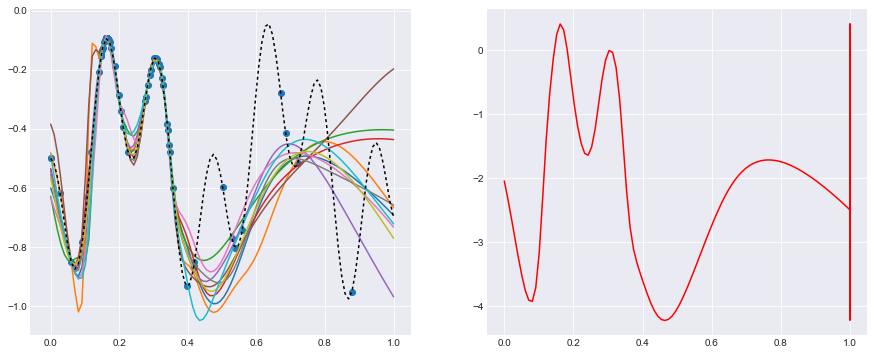

In [10]:
uid = "4941d626"
model_conf = get_model_conf(uid)
# bo = recreate_model(uid, model_conf, train=True, extra_args=dict(num_nn=10, epochs=1000, batch_size=1000))
bo = recreate_model(uid, model_conf, train=True, extra_args=dict(num_nn=10, epochs=1000, batch_size=1000, lr=0.001))
bo.model.ensemble_aggregator = np.mean
bo.plot_prediction(plot_predictions=True, plot_embedded_subspace=True)
bo.model.ensemble_aggregator = np.max
bo.plot_prediction(plot_predictions=True, plot_embedded_subspace=True)

reconstraining parameters linear.variances
/Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:

divide by zero encountered in log



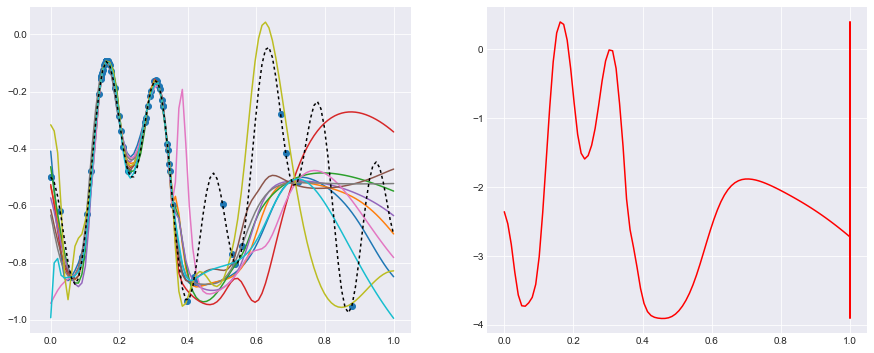

In [127]:
bo = recreate_model(uid, model_conf, train=True, extra_args=dict(num_nn=10, epochs=1000, batch_size=10, lr=0.001))
bo.model.ensemble_aggregator = np.mean
bo.plot_prediction(plot_predictions=True, plot_embedded_subspace=True)
bo.model.ensemble_aggregator = np.max
bo.plot_prediction(plot_predictions=True, plot_embedded_subspace=True)

# Ensemble hyperparameters

## Size

In [38]:
df_agg = select_group(df, 'funcs')
show_regret(df_agg, "branin")

['epoch' 'embedding' 'l2' 'ensemble_size' 'minibatch' 'funcs' 'highdim' nan]


reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance


interactive(children=(Dropdown(description='obj_func', index=1, options=('bohachevsky', 'branin', 'camelback',…

<function __main__.show_regret.<locals>.show_ir(obj_func)>

In [42]:
show_obj_func(df_agg, plot_predictions=False)

interactive(children=(Dropdown(description='obj_func', options=('branin', 'camelback'), value='branin'), Check…

<function __main__.show_obj_func.<locals>.show_prediction(obj_func, embedded)>

## Aggregator

In [39]:
df_agg = select_group(df, 'funcs')
show_regret(df_agg, "branin")

['epoch' 'embedding' 'l2' 'ensemble_size' 'minibatch' 'funcs' 'highdim' nan]


reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance
reconstraining parameters rbf.variance


interactive(children=(Dropdown(description='obj_func', index=1, options=('bohachevsky', 'branin', 'camelback',…

<function __main__.show_regret.<locals>.show_ir(obj_func)>

# Mini batches

In [37]:
df_agg = select_group(df, 'minibatch')
show_regret(df_agg)

['epoch' 'embedding' 'l2' 'ensemble_size' 'minibatch' 'funcs' 'highdim' nan]


interactive(children=(Dropdown(description='obj_func', options=('sintwo',), value='sintwo'), Output()), _dom_c…

<function __main__.show_regret.<locals>.show_ir(obj_func)>

# TODO

In [ ]:
- branin
- hartmann3
- hartmann6


- febo
    - rosenbrock-d, embedding
    - logistic regression mnist
    - DNGO, ensemble
- Publish HPC automation (CI on regret)
- Publish Docker container for robo and spearmint
- Big N (otherwise useless since simple GP outperforms for small N)
- Reuse NN weights


- voice concern regarding best case effectiveness of ensemble
- Not iid..
- propose: adaptive epochs

In [ ]:
- assume max
- and at step i.
- assume next sample same as previous samples.
-